In [0]:
!pip install pyro-ppl

# Bandits with unobserved confounders: A causal Approach

![Mult-armed bandit](https://github.com/Rdn03/CausalBandits/raw/preliminary_results/images/Multi-armed-bandit.png)

#### Akshay Suresh
#### Ankitha Kumari Moodukudru
#### Rutu Nanavati

# Outline

- **The multi-armed bandit problem**

- **The Greedy casino problem**

- **The drunk gambler**

- **Random sampling**

- **Thompson sampling**

- **Causal Thompson sampling**

- **Results**

- **Key learnings**

## The multi-armed bandit problem

- Consider n-slot machines $S_1,\ S_2,\ S_3\ ...\ S_n$. Given that the payouts of each slot machine is unknown, the goal is to come up with a sequence of actions that would maximize the reward.

- The multi-armed bandit problem revolves around developing a strategy in learning the true payout distributions of each of these slot machines.

# The Greedy casino problem

Consider this scenario, a greedy casino owner observes gamblers and their behavior so as to maximize the profits of the casino.

On observation, the casino owner learns that the choice of pulling an arm (of the slot machine) is influenced by 2 factors

- The gamber being drunk

- The machine blinking

**Suppose also that a new gambling law requires that casinos maintain a minimum attainable payout rate for slots of 30%. Cognizant of this new law, while still wanting to maximize profits by exploiting gamblers’ natural arm choices,
the casino executives modify their new slots with the payout rates depicted in this table**

<table>
    <tr>
        <th>(a)</th>
        <th colspan="2">D=0</th>
        <th colspan="2">D=1</th>
    </tr>
    <tr>
        <th></th>
        <th>B=0</th>
        <th>B=1</th>
        <th>B=0</th>
        <th>B=1</th>
    </tr>
    <tr>
        <td>X=M1</td>
        <td>0.1*</td>
        <td>0.5</td>
        <td>0.4</td>
        <td>0.2*</td>
    </tr>
    <tr>
        <td>X=M2</td>
        <td>0.5</td>
        <td>0.1*</td>
        <td>0.2*</td>
        <td>0.4</td>
    </tr>
</table>

$D=1$: gambler is drunk $P(D=1) = 0.5$

$B=1$: blinking machine $P(B=1) = 0.5$

$X = d \oplus b$: choice of arm

\* indicates the user preference. It can be seen that the gambler has a very low chance of winning given these preferences.

The DAG of the model would look something like this

![Model DAG](https://github.com/Rdn03/CausalBandits/raw/preliminary_results/images/DAG.png)

In [0]:
from pyro import distributions as dist
from torch import tensor
from pyro import sample, do
import numpy as np
from numpy import ones, zeros, array, log, argmax
from matplotlib.pyplot import hist
import matplotlib.pyplot as plt
from scipy.stats import beta
from pyro import set_rng_seed
from pandas import DataFrame

In [0]:
set_rng_seed(1618) # the golden ratio

In [0]:
N = 100 # Monte Carlo simulations

In [0]:
trials = 1000 # trials

In [0]:
n_bandits = 2 # number of bandits

In [0]:
class Game(object):
    """
    Simulation of the game
    drunk_probs: probability of a gambler being drunk
    blink_probs: probability that machine would be blinking
    payout_probs: probability of payout
    policy: an object of the Policy class containing two methods choose_arm() and update(Y)
    T: number of trials
    """
    def __init__(self, drunk_probs, blink_probs, payout_probs, policy, T):
        self.drunk_probs = drunk_probs
        self.blink_probs = blink_probs
        self.payout_probs = payout_probs
        self.policy = policy
        self.T = T
        
        # information about drunk and blinking
        self.config = [0.] * len(self.payout_probs[0])
        self.current_config = -1
        
        # rewards
        self.rewards = []
        
        # cumulative regret
        self.cumulative_regret = []
        self.chosen_arms = []
        self.best_arm_count = 0
        self.best_arm_prob = []
        
        # game context
        self.context = {}
        
    def generateContext(self):
        d = int(sample('D', dist.Bernoulli(self.drunk_probs)))
        b = int(sample('B', dist.Categorical(self.blink_probs)))
        self.context = {"d": d, "b": b}
    
    def model(self):
        # setup context
        self.current_config = self.context["b"] + 2* self.context["d"]
        
        # arm
        x = int(sample('X', dist.Delta(tensor(self.context["d"] ^ self.context["b"]))))
        
        # pull arm
        y = sample('Y', dist.Bernoulli(self.payout_probs[x][self.current_config]))
        
        # update stats
        self.config[self.current_config] += 1
        self.chosen_arm = x
        
        return y
    
    def play(self):
        for _ in range(self.T):
            # generate context
            self.generateContext()
            
            if self.policy is None:
                # pull
                Y = self.model()
            else: 
                # choose an arm
                self.chosen_arm = self.policy.choose_arm(self.context)
            
                # intervene and pull
                int_model = do(self.model, {'X': self.chosen_arm})
                Y = int_model()
            
                # update policy
                self.policy.update(Y)
            
            # update stats
            self.rewards.append(Y.item())
            self.chosen_arms.append(self.chosen_arm)
            self.cumulative_regret.append(self.regret())
            self.best_arm_prob.append(self.best_arm())
    
    def regret(self):
        return sum(self.payout_probs.max(dim=0)[0] * tensor(self.config)) - sum(self.rewards)
    
    def best_arm(self):
        # get the best arm for the current context
        best_val = np.argmax(self.payout_probs, axis=0)[self.current_config]
        self.best_arm_count += int(best_val == self.chosen_arm)
        return self.best_arm_count/len(self.chosen_arms)
      
    def stats(self):
        X_Y = []
        for k in [0.0, 1.0]:
            X_Y.append(len([self.rewards[i] for i in range(len(self.rewards)) if (self.rewards[i] == 1.0  and self.chosen_arms[i] == k)])\
                        /len([el for el in self.chosen_arms if el == k]))

        stats = [X_Y[0],X_Y[1]]


        return stats

# Drunk Gambler

The gamblers play based on their natural predilections

In [0]:
drunk_pr = tensor(0.5)
blink_pr = tensor([0.5, 0.5])

In [0]:
payout_pr = tensor([[0.1, 0.5, 0.4, 0.2],
                    [0.5, 0.1, 0.2, 0.4]])

In [0]:
drunk_regret = tensor([0.] * trials)
drunk_results = tensor([0.] * n_bandits)
for _ in range(N):
    game = Game(drunk_probs=drunk_pr, blink_probs=blink_pr, payout_probs=payout_pr, T=trials, policy=None)
    game.play()
    drunk_regret += tensor(game.cumulative_regret)
    drunk_results += tensor(game.stats())

In [0]:
DataFrame((drunk_results/N).tolist(), columns=["P(Y=1|X)"], index=["X=M1","X=M2"])

,P(Y=1|X)
X=M1,0.151453
X=M2,0.150486


On running a simulation of the drunk gambler playing based on this new set up, we would get the following results

# Gaming commission

The state decides to test if the 30% payout criterion is satisfied at this casino. This is done by choosing an arm based on a coin-flip i.e. $P(X=M_1) = P(X=M_2) = 0.5$

In [0]:
class Policy(object):
    def __init__(self):
        pass
    def update(self, Y):
        pass
    def choose_arm(self, context=None):
        pass

In [0]:
class RandomSampler(Policy):
    """
    Implementation of a Random Sampler where choosing each arm has equal probability
    n_bandits: Number of slot machines
  """
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
        self.params = [{"w": 0, "l": 0} for _ in range(self.n_bandits)]
        self.arm_selected = 0
        
    def update(self, Y):
        if Y == 1:
            self.params[self.arm_selected]["w"] += 1
        else:
            self.params[self.arm_selected]["l"] += 1
            
    def choose_arm(self, context=None):
        # each arm has an equal chance of being selected
        probs = [1/self.n_bandits] * self.n_bandits
        self.arm_selected = sample("arm_selected", dist.Categorical(tensor(probs)))
        return self.arm_selected

In [0]:
commission_regret = tensor([0.] * trials)
commission_best_arm = tensor([0.] * trials)
commission_results = tensor([0.] * n_bandits)
for _ in range(N):
    game = Game(drunk_probs=drunk_pr, blink_probs=blink_pr, payout_probs=payout_pr, T=trials, policy=RandomSampler(n_bandits=n_bandits))
    game.play()
    commission_regret += tensor(game.cumulative_regret)
    commission_best_arm += tensor(game.best_arm_prob)
    commission_results += tensor(game.stats())

On running a simulation of the gaming commission verifying the 30% payout, we would get the following results

In [0]:
DataFrame((commission_results/N).tolist(), columns=["P(Y=1|X)"], index=["X=M1","X=M2"])

,P(Y=1|X)
X=M1,0.301406
X=M2,0.296990


It can be seen from the results that:
    
- The two arms are indistinguishable.

- A user choosing based on natural predilections has a lower chance of winning.

- The gaming commission conclude that the 30% criteria has been met.

# Thompson sampling

Thompson sampling is a very well known algorithm used widely in multi-class bandit problems.

In [0]:
class ThompsonSampler(Policy):
    """
    Implementation of Causal Thompson sampling 
    n_bandits: Number of slot machines
  """
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
        # keep track of rewards for each arm
        self.params = [{"a": 1, "b": 1} for _ in range(self.n_bandits)]
        self.arm_selected = 0
    
    def update(self, Y):
        # update parameters based on payout
        if Y == 1:
            self.params[self.arm_selected]["a"] += 1
        else:
            self.params[self.arm_selected]["b"] += 1
            
    def choose_arm(self, context=None):
        # determine weights based on past rewards
        probs = [el["a"]/(el["a"] + el["b"]) for el in self.params]
        
        # sample arm from a categorical distribution
        self.arm_selected = sample("arm_selected", dist.Categorical(tensor(probs)))
        return self.arm_selected

In [0]:
thompson_regret = tensor([0.] * trials)
thompson_best_arm = tensor([0.] * trials)
thompson_results = tensor([0.] * n_bandits)
for _ in range(N):
    game = Game(drunk_probs=drunk_pr, blink_probs=blink_pr, payout_probs=payout_pr, T=trials, policy=ThompsonSampler(n_bandits=n_bandits))
    game.play()
    thompson_regret += tensor(game.cumulative_regret)
    thompson_best_arm += tensor(game.best_arm_prob)
    thompson_results += tensor(game.stats())

On running simulations of Thompson sampling, we get the following results

In [0]:
DataFrame((thompson_results/N).tolist(), columns=["P(Y=1|X)"], index=["X=M1","X=M2"])

,P(Y=1|X)
X=M1,0.296736
X=M2,0.300095


# Causal Thompson sampling

This is a new sampling method developed to account for unobserved confounders while sampling. Thompson sampling does not perform particularly well when there are unobserved confounders.

## How Causal Thompson sampling works

A causal thompson sampler takes into account the users intuition to play an arm and suggests an introspection comparing the odds of winning following his intuition or going against it. It considers using the rule that compares the average payouts obtained by players for choosing in favour or against their intuition. This procedure is called regret decision criteria. We exploit the fact that a superior arm will emerge quickly by weighting the favorable arm by making it more likely to be chosen early in the learning process.

In [0]:
class CausalThompsonSampler(Policy):
    """
        Implementation of Causal Thompson sampling 
        n_bandits: Number of slot machines
        payout_pr: Probability of payout
    """
    def __init__(self, n_bandits, payout_pr):
        self.n_bandits = n_bandits
        
        # success and failure counts of playing an arm (Observation)
        self.s = ones((2,2))
        self.f = ones((2,2))
      
        # arm selected based on the causal thompson policy
 
        self.arm_selected = 0
        
        # arm based on intuition
        self.x_intuition = 0
        
        # P(Y=1|X=0, Z=0) * 100 , Z is the intuition 
        self.s[0][0] = (payout_pr[0][0] + payout_pr[0][3]) * 100/2 
        
        # P(Y=1|X=1, Z=1) * 100 
        self.s[1][1] = (payout_pr[1][1] + payout_pr[1][2]) * 100/2
        
        # P(Y=0|X=0, Z=0) * 100 
        self.f[0][0] = (1 - payout_pr[0][0] + 1 - payout_pr[0][3]) * 100/ 2
        
        # P(Y=0|X=1, Z=1) * 100 
        self.f[1][1] = (1 - payout_pr[1][1] + 1 - payout_pr[1][2]) * 100/2    
        
        # P(Y=1|X) Probability of payout for each arm by observation 
        self.p_Y_X = [self.s[i][i]/(self.s[i][i] + self.f[i][i]) for i in range(self.n_bandits)]
        
        # updated probability of payout for each arm 
        self.theta = [0, 0]   
        
        
    def update(self, reward):
        # update the count of payouts
        self.s[self.x_intuition][self.arm_selected] += int(reward)
        self.f[self.x_intuition][self.arm_selected] += 1 - int(reward)   
  
    def choose_arm(self, context=None): 
        # get the context
        d = context["d"]
        b = context["b"]
        # arm to be played according to players natural predilection
        self.x_intuition = int(sample('Z', dist.Delta(tensor(d^b))))
        
        # counter intuition, if x is 0, x' is 1 else 0
        x_prime = 1 - self.x_intuition 
        
        # P(Y=1|do(X=x)) 
        p_Y_doX_Z = [[self.s[i][0]/(self.s[i][0] + self.f[i][0]), self.s[i][1]/(self.s[i][1] + self.f[i][1])] for i in range(self.n_bandits)] 

        # E(YX=x' |X = x) estimated payout for counter intuition
        Q1 = p_Y_doX_Z[self.x_intuition][x_prime]
        
        # P(y|X = x) , estimated payout for intuiton
        Q2 = self.p_Y_X[self.x_intuition] 
        
        # ETT
        bias = abs(Q1- Q2)
         
        # initialize weights
        w = ones(2)
        
        if np.isnan(bias):
            weight = 1
        else:
            weight = 1 - bias
         
        # choose arm to bias        
        if Q1 > Q2:
            w[self.x_intuition] = weight
        else:
            w[x_prime] = weight
        
        # choose arm
        self.theta = [sample("theta_0", dist.Beta(self.s[self.x_intuition][0], self.f[self.x_intuition][0])) * w[0],  sample("theta_1", dist.Beta(self.s[self.x_intuition][1], self.f[self.x_intuition][1])) * w[1]]
        self.arm_selected = self.theta.index(max(self.theta))
        return self.arm_selected

In [0]:
causal_regret = tensor([0.] * trials)
causal_best_arm = tensor([0.] * trials)
causal_results = tensor([0.] * n_bandits)
for _ in range(N):
    game = Game(drunk_probs=drunk_pr, blink_probs=blink_pr, payout_probs=payout_pr, T=trials, policy=CausalThompsonSampler(n_bandits=n_bandits, payout_pr=payout_pr))
    game.play()
    causal_regret += tensor(game.cumulative_regret)
    causal_best_arm += tensor(game.best_arm_prob)
    causal_results += tensor(game.stats())

On running simulations of Causal Thompson sampling, we get the following results

In [0]:
DataFrame((causal_results/N).tolist(), columns=["P(Y=1|X)"], index=["X=M1","X=M2"])

,P(Y=1|X)
X=M1,0.449372
X=M2,0.449666


# Results

*Cumulative regret for each policy*

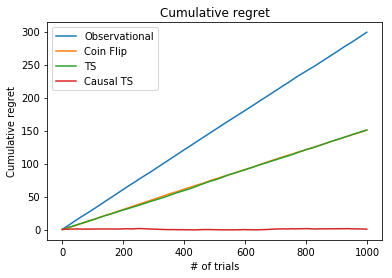

In [0]:
plt.figure()
plt.title("Cumulative regret")
plt.xlabel("# of trials")
plt.ylabel("Cumulative regret")
plt.plot([el.item() for el in list(drunk_regret/N)], label="Observational")
plt.plot([el.item() for el in list(commission_regret/N)], label="Coin Flip")
plt.plot([el.item() for el in list(thompson_regret/N)], label="TS")
plt.plot([el.item() for el in list(causal_regret/N)], label="Causal TS")
plt.legend()
plt.show()

*Probability of choosing the best arm for each policy*

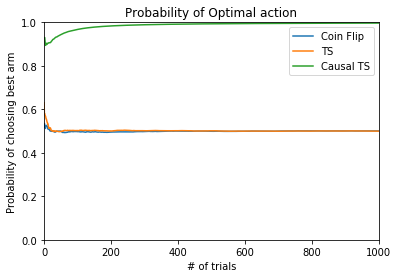

In [0]:
plt.figure()
plt.axis([0,1000, 0, 1.0])
plt.title("Probability of Optimal action")
plt.plot([el.item() for el in list(commission_best_arm/N)], label="Coin Flip")
plt.plot([el.item() for el in list(thompson_best_arm/N)], label="TS")
plt.plot([el.item() for el in list(causal_best_arm/N)], label="Causal TS")
plt.xlabel("# of trials")
plt.ylabel("Probability of choosing best arm")
plt.legend()
plt.show()

# Key learnings

These are the key learnings from the project

1) Understanding of multi-armed bandit problems

2) Understanding of Thompson sampling and its use in developing an optimal strategy

3) Effect of Thompson sampling in presence of unobserved confounders

4) Viewing the multi-armed bandit problem as a causal one

5) Performing counterfactual reasoning using Causal Thompson sampling

# References

[1]  [Bayesian methods for hackers , Cameron Davidson-Pilon](http://ptgmedia.pearsoncmg.com/images/9780133902839/samplepages/9780133902839.pdf)

[2]  https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/Chapter6_Priorities

[3] [Causal Inference in Statistics  An Overview](https://ftp.cs.ucla.edu/pub/stat_ser/r350.pdf)

[4] [Bandits with Unobserved Confounders: A Causal Approach](https://papers.nips.cc/paper/5692-bandits-with-unobserved-confounders-a-causal-approach.pdf)

[5] https://github.com/ucla-csl/mabuc

[6] [Bandit Algorithms for Website Optimization](https://doc.lagout.org/science/0_Computer%20Science/2_Algorithms/Bandit%20Algorithms%20for%20Website%20Optimization%20%5BWhite%202013-01-03%5D.pdf)


